### [Dacon] Anomoly Detection
* 정상과 이상치 구별

In [1]:
import numpy as np
import pandas as pd
import os
import cv2

# 데이터프레임 생성
def make_dataframe():
    train_df = pd.read_csv('../input/dacon-cv-data/open/train_df.csv', index_col=0)
    test_df = pd.read_csv('../input/dacon-cv-data/open/test_df.csv', index_col=0)
    
    for index, row in train_df.iterrows():
        train_df.loc[index,'path'] = '/kaggle/input/dacon-cv-data/open/train/train/' + row['file_name']
    
    for index, row in test_df.iterrows():
        test_df.loc[index,'path'] = '/kaggle/input/dacon-cv-data/open/test/test/' + row['file_name']
    
    return train_df, test_df

In [2]:
pd.set_option('display.max_colwidth', 200)
train_df, test_df = make_dataframe()
print('train_df shape:', train_df.shape)
print('image shape: ', cv2.imread(train_df.loc[0, 'path']).shape)
train_df.head()

train_df shape: (4277, 5)
image shape:  (1024, 1024, 3)


,file_name,class,state,label,path
index,,,,,
0,10000.png,transistor,good,transistor-good,/kaggle/input/dacon-cv-data/open/train/train/10000.png
1,10001.png,capsule,good,capsule-good,/kaggle/input/dacon-cv-data/open/train/train/10001.png
2,10002.png,transistor,good,transistor-good,/kaggle/input/dacon-cv-data/open/train/train/10002.png
3,10003.png,wood,good,wood-good,/kaggle/input/dacon-cv-data/open/train/train/10003.png
4,10004.png,bottle,good,bottle-good,/kaggle/input/dacon-cv-data/open/train/train/10004.png


### Sequence Dataset

In [24]:
from tensorflow.keras.utils import Sequence
import sklearn 
import cv2

# 배치 크기와 이미지 크기를 전역 변수로 선언 
BATCH_SIZE = 64
IMAGE_SIZE = 224

#__init__(), __len__(), __getitem__(), on_epoch_end()
class CnD_Dataset(Sequence):
    def __init__(self, image_filenames, labels=None, batch_size=BATCH_SIZE, augmentor=None, shuffle=False, pre_func=None):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle = shuffle
        self.pre_func = pre_func
        if self.shuffle:
            #한번 섞을때
            #self.on_epoch_end()
            pass
        
    def __len__(self):
        # steps 계산
        return int(np.ceil(len(self.image_filenames)/self.batch_size))
        
    def __getitem__(self, index):
        # index는 스텝의 번호
            
        image_name_batch = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
        # image_name_batch 대신 batch_size로 하면 개수가 달라질 수 있음(맨 마지막 부분 땜에)
        image_batch = np.zeros((image_name_batch.shape[0],IMAGE_SIZE,IMAGE_SIZE,3))
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            if self.augmentor is not None:
                image = self.augmentor(image=image)['image']
                if self.pre_func is not None:
                    image = self.pre_func(image)
                image_batch[image_index] = image
        if self.labels is not None:
            return image_batch, label_batch
        else:
            return image_batch
        
    def on_epoch_end(self):
        if(self.shuffle):
             self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
             pass

In [4]:
import albumentations as A

# image file의 위치가 있는 데이터와 label값을 numpy array로 변환. 
train_image_filenames = train_df['path'].values
train_image_labels = train_df['label'].values

cnd_augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5)
])


cnd_ds = CnD_Dataset(train_image_filenames, train_image_labels, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, shuffle=False)

In [5]:
images_batch = next(iter(cnd_ds))[0]
labels_batch = next(iter(cnd_ds))[1]
print(images_batch.shape, labels_batch.shape)
print(images_batch[0])

(64, 224, 224, 3) (64,)
[[[145. 104.  90.]
  [147. 104.  88.]
  [145. 104.  93.]
  ...
  [149. 104.  89.]
  [150. 103.  90.]
  [148. 103.  87.]]

 [[149. 105.  91.]
  [150. 105.  94.]
  [150. 104.  93.]
  ...
  [152. 105.  91.]
  [152. 105.  90.]
  [152. 105.  91.]]

 [[148. 108.  93.]
  [148. 108.  94.]
  [154. 111.  90.]
  ...
  [149. 104.  92.]
  [150. 105.  93.]
  [151. 105.  93.]]

 ...

 [[157. 110.  99.]
  [151. 107.  92.]
  [154. 107.  95.]
  ...
  [145. 101.  91.]
  [138. 100.  89.]
  [141. 100.  90.]]

 [[155. 107.  95.]
  [151. 107.  91.]
  [149. 106.  94.]
  ...
  [139.  99.  87.]
  [139.  98.  87.]
  [138.  99.  90.]]

 [[152. 108.  92.]
  [151. 108.  93.]
  [153. 109.  95.]
  ...
  [143. 102.  90.]
  [144. 102.  89.]
  [142. 100.  87.]]]


#### **Visualization**

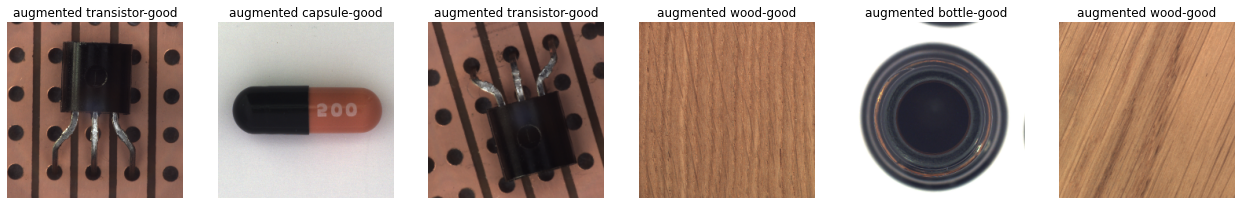

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 

def show_grid_images(images_batch, ncols=4, title=None):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        # image_batch는 float형이므로 int형으로 변경하여 이미지 시각화
        axs[i].imshow(np.array(images_batch[i], dtype='int32'))
        axs[i].axis('off')
        axs[i].set_title(title[i]) 
        
show_grid_images(images_batch, ncols=6, title='augmented ' + labels_batch)

In [36]:
# 학습용과 검증용으로 나누기
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_path = train_df['path'].values
label = (train_df['label']).values
encoder = LabelEncoder()
encoder.fit(label)
train_label = encoder.transform(label)
print(train_label.shape)

tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size=0.15, random_state=2022)
print('학습용 path shape:', tr_path.shape, '검증용 path shape:', val_path.shape, 
      '학습용 label shape:', tr_label.shape, '검증용 label shape:', val_label.shape)

(4277,)
학습용 path shape: (3635,) 검증용 path shape: (642,) 학습용 label shape: (3635,) 검증용 label shape: (642,)


In [40]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input

tr_ds = CnD_Dataset(tr_path, tr_label, batch_size=BATCH_SIZE, augmentor=cnd_augmentor, 
                      shuffle=True, pre_func=xcp_preprocess_input)
val_ds = CnD_Dataset(val_path, val_label, batch_size=BATCH_SIZE, augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)

tr_image_batch = next(iter(tr_ds))[0]
val_image_batch = next(iter(val_ds))[0]
print(tr_image_batch.shape, val_image_batch.shape)

(64, 224, 224, 3) (64, 224, 224, 3)


#### **Modeling**

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception, MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    output = Dense(tr_label.shape[0], activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model

In [41]:
model = create_model(model_name='xception')
model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=1)
# 5번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [42]:
N_EPOCHS = 15
history = model.fit(tr_ds, epochs=N_EPOCHS,
                    validation_data=val_ds,
                   callbacks=([rlr_cb, ely_cb]), verbose=1)

Epoch 1/15
57/57 [==============================] - 158s 3s/step - loss: 3.1930 - accuracy: 0.7395 - val_loss: 3.9998 - val_accuracy: 0.0545
Epoch 2/15
57/57 [==============================] - 149s 3s/step - loss: 0.8513 - accuracy: 0.8446 - val_loss: 6.2973 - val_accuracy: 0.0545
Epoch 3/15
57/57 [==============================] - 147s 3s/step - loss: 0.6806 - accuracy: 0.8468 - val_loss: 6.7535 - val_accuracy: 0.0498
Epoch 4/15
57/57 [==============================] - 146s 3s/step - loss: 0.6063 - accuracy: 0.8542 - val_loss: 5.1856 - val_accuracy: 0.0498

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/15
57/57 [==============================] - 147s 3s/step - loss: 0.5044 - accuracy: 0.8608 - val_loss: 6.6590 - val_accuracy: 0.0498
Epoch 6/15
57/57 [==============================] - 147s 3s/step - loss: 0.4522 - accuracy: 0.8666 - val_loss: 7.3046 - val_accuracy: 0.0498
Epoch 00006: early stopping


In [43]:
# 테스트 데이터의 image path와 label을 Numpy array로 변환 및 Label encoding
test_path = test_df['path'].values

test_ds = CnD_Dataset(test_path, batch_size=BATCH_SIZE,labels=None,augmentor=None, 
                       shuffle=False, pre_func=xcp_preprocess_input)
preds = model.predict(test_ds)

In [47]:
predicted_class = np.argmax(preds, axis=1)
print(predicted_class)
submission = pd.read_csv('../input/dacon-cv-data/open/sample_submission.csv')
submission['label'] = encoder.inverse_transform(predicted_class)

[76 76 76 ... 76 76 76]


In [51]:
# submission을 csv 파일로 저장
submission.to_csv('./sample_submission_v1.0.csv', index=False)

* 데이터에 맞는 Augmentation과 모델 커스텀이 필수적이라고 생각.
* 현재 과적합으로 인해 테스트데이터 예측성능이 떨어짐
* LabelEncoder 라벨값이 많이 나오는 이유 찾아보기
* 불균형 데이터이므로 이상치 데이터를 거의 학습하지 못함